# Author: Kristian

In [4]:
import os 
from pathlib import Path
from dotenv import load_dotenv, find_dotenv

basepath = Path(os.getcwd())
# make sure your working directory is the repository root.
if basepath.name != "idp-radio-1":
    os.chdir(basepath.parent.parent)
    
import os 
import tensorflow as tf
from pathlib import Path

# Specify which GPU(s) to use
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Or 2, 3, etc. other than 0

#config = tf.compat.v1.ConfigProto(device_count={'GPU': 1}, allow_soft_placement=True, log_device_placement=True)
config = tf.compat.v1.ConfigProto(allow_soft_placement=True, log_device_placement=True)
config.gpu_options.allow_growth = True
#config.gpu_options.per_process_gpu_memory_fraction = 1.2
tf.compat.v1.Session(config=config)
tf.__version__

from tensorflow.keras.applications.densenet import DenseNet121

from src.metrics.metrics import F2Score
from src.metrics.losses import WeightedBinaryCrossentropy, compute_class_weight
from src.architectures.simple.simple_base import SimpleBaseArchitecture
from src.utils.save_model import get_experiment, load_model
from src.architectures.benchmarks.benchmark_definitions import benchmark_from_logs, simple_architecture_experiment, CHEXPERT_COLUMNS
from src.utils.crm import CRM

%load_ext autoreload
%autoreload 2

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
MODEL_ID = '1a955742-e3ff-11ea-bd3d-0242ac110005'
ARCHITECTURE = DenseNet121
NUM_CLASSES = 12

In [6]:
exp_dict = get_experiment(identifier=MODEL_ID)
benchmark = benchmark_from_logs(exp_dict['benchmark'])

Initialzed custom_binary_crossentropy with epsilon 1e-05


In [7]:
def build_model():
    model = SimpleBaseArchitecture(ARCHITECTURE, NUM_CLASSES, train_last_layer_only=False)
    path = str(load_model(identifier=MODEL_ID))
    model.load_weights(path)

    return model

In [8]:
model = build_model()

In [9]:
crm = CRM(model, benchmark.label_columns, dims=(256, 256))

Model prediction:
	Edema          	(4)	with probability 	0.4023677408695221
	Lung Opacity   	(2)	with probability 	0.35558009147644043
	Cardiomegaly   	(1)	with probability 	0.35137858986854553
	Atelectasis    	(7)	with probability 	0.25491002202033997
	Enlarged Cardiomediastinum	(0)	with probability 	0.2425673007965088
	Consolidation  	(5)	with probability 	0.07012450695037842
	Pneumonia      	(6)	with probability 	0.06869635730981827


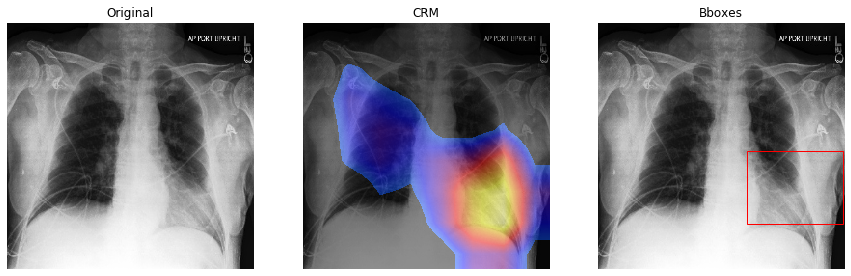

In [54]:
image = 'data/chexpert/full/CheXpert-v1.0-small/valid/patient64541/study1/view1_frontal.jpg'

# for thresh in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]:
crm.generate_crm_combined_plot(image, 0.3)

Edema          (4)with probability 0.4023677408695221


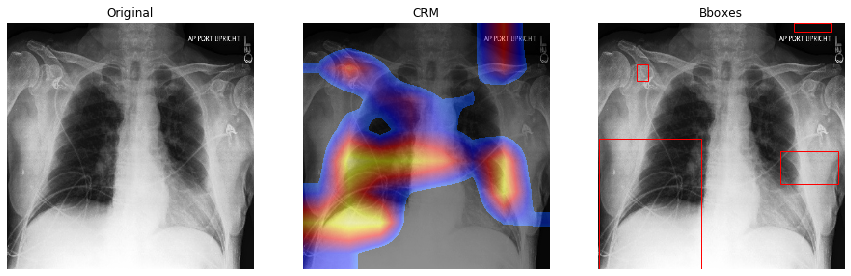

Lung Opacity   (2)with probability 0.35558009147644043


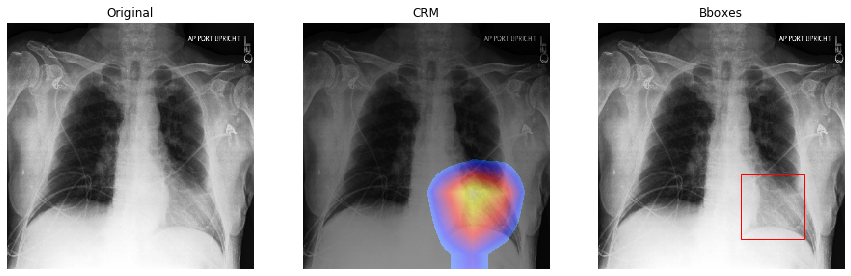

Cardiomegaly   (1)with probability 0.35137858986854553


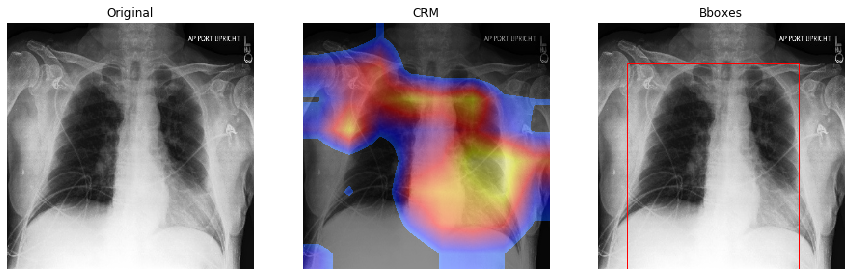

In [55]:
crm.generate_crm_class_plot(image, 0.3)